Cluster network training and testing

Ref:
Xie, J., Girshick, R., & Farhadi, A. (2016). Unsupervised deep embedding for clustering analysis. 33rd International Conference on Machine Learning, ICML 2016, 1, 740–749.

In [1]:
import  tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import os
os.environ["OMP_NUM_THREADS"] = '4'
import scipy.io as scio
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import ConvLSTM2D, Dense, LeakyReLU, Multiply
from tensorflow.keras.layers import BatchNormalization, Lambda, Multiply, Add
from sklearn.metrics import roc_curve, auc
import numpy as np
import random
import math
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.svm import SVC
from tqdm import tqdm
from tools import *
from sklearn.manifold import TSNE
tf.set_random_seed(1)
np.random.seed(1)
random.seed(1)
# wind records on the 3rd glide path
all_corridor = all_2017_data_read(loc=3)
pilot_corridor_2017,pilot_time_2017,pilot_wtws_2017,pilot_aware_2017 = pilot_corridor_read(2017,loc=3)
pilot_corridor_2018,pilot_time_2018,pilot_wtws_2018,pilot_aware_2018 = pilot_corridor_read(2018,loc=3)
pilot_corridor_2019,pilot_time_2019,pilot_wtws_2019,pilot_aware_2019 = pilot_corridor_read(2019,loc=3)
pilot_corridor_2020,pilot_time_2020,pilot_wtws_2020,pilot_aware_2020 = pilot_corridor_read(2020,loc=3)

unlabeled_data = all_corridor
pilot_corridor = np.vstack((pilot_corridor_2017))#
pilot_test = np.vstack((pilot_corridor_2018,pilot_corridor_2019,pilot_corridor_2020))

wtws_acc_2017 = np.sum(pilot_wtws_2017)
aware_acc_2017 = np.sum(pilot_aware_2017)
wtws_acc_test = np.sum(np.hstack((pilot_wtws_2020,pilot_wtws_2018,pilot_wtws_2019)))
aware_acc_test = np.sum(np.hstack((pilot_aware_2020,pilot_aware_2018,pilot_aware_2019)))

# wind records on the 4th glide path
all_corridor = all_2017_data_read(loc=4)
pilot_corridor_2017,pilot_time_2017,pilot_wtws_2017,pilot_aware_2017 = pilot_corridor_read(2017,loc=4)
pilot_corridor_2018,pilot_time_2018,pilot_wtws_2018,pilot_aware_2018 = pilot_corridor_read(2018,loc=4)
pilot_corridor_2019,pilot_time_2019,pilot_wtws_2019,pilot_aware_2019 = pilot_corridor_read(2019,loc=4)
pilot_corridor_2020,pilot_time_2020,pilot_wtws_2020,pilot_aware_2020 = pilot_corridor_read(2020,loc=4)

unlabeled_data = np.vstack((all_corridor,unlabeled_data))
pilot_corridor = np.vstack((pilot_corridor_2017,pilot_corridor))
pilot_test = np.vstack((pilot_corridor_2018,pilot_corridor_2019,pilot_corridor_2020,pilot_test))

# Accuracy of the operational systems
wtws_acc_2017 = wtws_acc_2017+np.sum(pilot_wtws_2017)
aware_acc_2017 = aware_acc_2017+np.sum(pilot_aware_2017)
wtws_acc_test = wtws_acc_test+np.sum(np.hstack((pilot_wtws_2020,pilot_wtws_2018,pilot_wtws_2019)))
aware_acc_test = aware_acc_test+np.sum(np.hstack((pilot_aware_2020,pilot_aware_2018,pilot_aware_2019)))
wtws_acc_2017 = wtws_acc_2017 / pilot_corridor.shape[0]
aware_acc_2017 = aware_acc_2017 / pilot_corridor.shape[0]
wtws_acc_test = wtws_acc_test / pilot_test.shape[0]
aware_acc_test = aware_acc_test / pilot_test.shape[0]

DATA_NUM = unlabeled_data.shape[0]
still_index = np.argsort(np.max(unlabeled_data,axis = 1)-np.min(unlabeled_data,axis = 1))

std = preprocessing.StandardScaler()
unlabeled_data = std.fit_transform(unlabeled_data)
pilot_corridor = std.transform(pilot_corridor)
pilot_test = std.transform(pilot_test)

index_list = [i for i in range(DATA_NUM)]
BATCH_SIZE = 1024
N_CLUSTER = 2
encodede_dim = 4
cluster_dim = 4


In [2]:
def _test_cluster(clusternn,hazard_id):
    '''Test with 2021 data'''
    pilot_encoded_test, pilot_pred_test, cluster_features_test = sess.run([clusternn.encoded,clusternn.pred, clusternn.cluster_features],
                                                      feed_dict={clusternn.input: pilot_test, \
                                                                 clusternn.input_batch_size:
                                                                     pilot_test.shape[
                                                                         0]})
    si_acc = np.sum(pilot_pred_test == hazard_id) / pilot_pred_test.shape[0]
    return pilot_encoded_test,pilot_pred_test, cluster_features_test
class cluster_NN(object):
    def __init__(self, N_CLUSTER,cluster_dim):
        self.n_cluster = N_CLUSTER
        self.kmeans = KMeans(n_clusters=N_CLUSTER, n_init=20)
        self.svc = SVC(kernel='linear')
        # model setup
        self.input = tf.placeholder(tf.float32, shape=[None, 115])
        self.input_batch_size = tf.placeholder(tf.int32, shape=())

        self.w1 = tf.Variable(tf.random_normal(shape=(115, 64), stddev=0.01,seed=10), name='w1')
        self.b1 = tf.Variable(tf.zeros(shape=(64,)), name='b1')
        self.w2 = tf.Variable(tf.random_normal(shape=(64, 32), stddev=0.01,seed=10), name='w2')
        self.b2 = tf.Variable(tf.zeros(shape=(32,)), name='b2')
        self.w3 = tf.Variable(tf.random_normal(shape=(32, encodede_dim), stddev=0.01,seed=10), name='w3')
        self.b3 = tf.Variable(tf.zeros(shape=(encodede_dim,)), name='b3')
        self.w4 = tf.Variable(tf.random_normal(shape=(encodede_dim, 32), stddev=0.01,seed=10), name='w4')
        self.b4 = tf.Variable(tf.zeros(shape=(32,)), name='b4')
        self.w5 = tf.Variable(tf.random_normal(shape=(32, 64), stddev=0.01,seed=10), name='w5')
        self.b5 = tf.Variable(tf.zeros(shape=(64,)), name='b5')
        self.w6 = tf.Variable(tf.random_normal(shape=(64, 115), stddev=0.01,seed=10), name='w6')
        self.b6 = tf.Variable(tf.zeros(shape=(115,)), name='b6')

        self.encoded, self.decoded = self.ae_setup(self.input)
        self.w7 = tf.Variable(tf.random_normal(shape=(encodede_dim, cluster_dim), stddev=1, seed=10), name='w7')
        self.b7 = tf.Variable(tf.zeros(shape=(cluster_dim,)), name='b7')
        self.cluster_features_data = self.clusnn_setup(self.encoded)
        self.cluster_features = self.cluster_features_data
        self.cluster_feature_dim = cluster_dim 
        self.B_update = tf.Variable(tf.zeros(shape=(N_CLUSTER, self.cluster_feature_dim)), name="B_update")
        self.dist = self._pairwise_euclidean_distance(self.cluster_features, self.B_update, self.input_batch_size,
                                                      N_CLUSTER)
        self.pred = tf.argmin(self.dist, 1)
        self.T = (tf.one_hot(self.pred, N_CLUSTER))
        q = 1.0 / (1.0 + self.dist ** 2)  # REF: dec
        self.q = (q / tf.reduce_sum(q, axis=1, keepdims=True))
        self.p = tf.placeholder(tf.float32, shape=(None, N_CLUSTER))
        self.loss_dec = self._kl_divergence(self.p, self.q)
        self.reconstruct_loss = tf.losses.mean_squared_error(self.decoded, self.input)

        # introduce some hazardous wind reports by pilots as prior information
        self.pilot_input = tf.placeholder(tf.float32, shape=[None, 115])
        self.pilot_size = tf.placeholder(tf.int32, shape=())
        self.pilot_encoded, self.pilot_decoded = self.ae_setup(self.pilot_input)
        self.pilot_cluster_features_data = self.clusnn_setup(self.pilot_encoded)
        self.pilot_center = tf.reshape(self.pilot_input[0, ::],
                                       [1, -1])  # tf.reshape(tf.reduce_mean(self.pilot_input,axis = 0),[1,-1])
        center_encoded, center_decoded = self.ae_setup(self.pilot_center)
        self.pilot_center_cluster_features = self.clusnn_setup(center_encoded)
        self.pilot_center_dist = (self.pilot_cluster_features_data - self.pilot_center_cluster_features) ** 2
        self.pilot_among_dists = self._pairwise_euclidean_distance(self.pilot_cluster_features_data,
                                                                   self.pilot_cluster_features_data, self.pilot_size,
                                                                   self.pilot_size)
        self.pilot_loss = tf.reduce_mean((tf.reduce_sum(self.pilot_center_dist, axis=1)))  # 使飞行员分类在第一类

        # introduce some calm winds as prior information
        self.true_input = tf.placeholder(tf.float32, shape=[None, 115])
        self.true_size = tf.placeholder(tf.int32, shape=())
        self.true_encoded, self.true_decoded = self.ae_setup(self.true_input)
        self.true_cluster_features_data = self.clusnn_setup(self.true_encoded)
        self.true_center = tf.zeros(shape=(1, 115))
        center_encoded, center_decoded = self.ae_setup(self.true_center)
        self.true_center_cluster_features = self.clusnn_setup(center_encoded)  # self.clusnn_setup(center_encoded)
        self.true_center_dist = (self.true_cluster_features_data - self.true_center_cluster_features) ** 2
        self.true_among_dists = self._pairwise_euclidean_distance(self.true_cluster_features_data,
                                                                  self.true_cluster_features_data, self.true_size,
                                                                  self.true_size)
        self.true_loss = tf.reduce_mean((tf.reduce_sum(self.true_center_dist, axis=1)))
        true_pilot_interval = self._pairwise_euclidean_distance(self.true_cluster_features_data,
                                                                self.pilot_cluster_features_data, self.true_size,
                                                                self.pilot_size)
        self.max_interval = -(tf.reduce_mean(true_pilot_interval) * 1)
        pilot_true_center = tf.concat([self.pilot_center_cluster_features, self.true_center_cluster_features], axis=0)
        dist2 = self._pairwise_euclidean_distance(self.cluster_features, pilot_true_center, self.input_batch_size, N_CLUSTER)
        q = 1.0 / (1.0 + dist2)  # REF: dec
        q = (q / tf.reduce_sum(q, axis=1, keepdims=True))
        self.class_loss = tf.reduce_mean(q[:, 0])
        self.w_loss = tf.reduce_mean((self.w7) ** 2) 
        self.loss_supervise = 1 * self.reconstruct_loss + 1 * self.loss_dec+0.005* self.pilot_loss+ 0.02*self.true_loss\
        + 0.04 * self.max_interval+ 1 * self.class_loss
        self.optimizer_dec = tf.train.AdamOptimizer(0.001).minimize(self.loss_supervise)
        self.loss_pretrain = self.reconstruct_loss  # +self.w_loss*0.01
        self.optimizer_pretrain = tf.train.AdamOptimizer(0.005).minimize(self.loss_pretrain)

    def clusnn_setup(self, encoded):
        cluster_features = (tf.matmul(encoded, self.w7) + self.b7) 
        return cluster_features
    def svm_para_cal(self,pred_,cluster_features_):
        a = np.zeros(shape=(2, 1))
        b = np.zeros(shape=(1, ))
        if np.unique(pred_).shape[0]>1:
            svc = self.svc.fit(cluster_features_,pred_)
            a = svc.coef_.T
            b = svc.intercept_
        return tf.assign(self.w8, a),tf.assign(self.b8, b)
    def ae_setup(self,input):
        x = tf.nn.relu(tf.matmul(input, self.w1) + self.b1)
        x = tf.nn.relu(tf.matmul(x, self.w2) + self.b2)
        encoded = (tf.matmul(x, self.w3) + self.b3)
        x = tf.nn.relu(tf.matmul(encoded, self.w4) + self.b4)
        x = tf.nn.relu(tf.matmul(x, self.w5) + self.b5)
        decoded = (tf.matmul(x, self.w6) + self.b6)
        return encoded,decoded
    def _pairwise_euclidean_distance(self, a, b, input_batch_size,center_nums):
        p1 = tf.matmul(
            tf.expand_dims(tf.reduce_sum(tf.square(a), 1), 1),
            tf.ones(shape=(1, center_nums))
        )
        p2 = tf.transpose(tf.matmul(
            tf.reshape(tf.reduce_sum(tf.square(b), 1), shape=[-1, 1]),
            tf.ones(shape=(input_batch_size, 1)),
            transpose_b=True
        ))
        res = tf.sqrt(tf.abs(tf.add(p1, p2) - 2 * tf.matmul(a, b, transpose_b=True))+1e-4)
        return res

    def _kl_divergence(self, target, pred):
        return tf.reduce_mean(tf.reduce_sum(target * tf.log(target / (pred)), axis=1))

    def target_distribution(self, q):
        p = q**2 / q.sum(axis=0)
        p = p / p.sum(axis=1, keepdims=True)
        return p
    def get_assign_cluster_centers_op(self, features):
        kmeans = self.kmeans.fit(features)
        kmeans.cluster_centers_ = kmeans.cluster_centers_[np.argsort(np.sum(kmeans.cluster_centers_**2,1))]
        return tf.assign(self.B_update, kmeans.cluster_centers_)

    def get_assign_B_undate_op(self,features,T_):
        B_update = np.zeros((N_CLUSTER,self.cluster_feature_dim))
        for i in range(N_CLUSTER):
            B_update[i,::] = np.mean(features[np.where(T_[:,i]==1)[0],::],axis = 0).reshape(1,-1)
            if np.isnan(B_update[i,0]):
                idx = random.randint(0, BATCH_SIZE-1)
                B_update[i,::] = features[idx,::]
        B_update = B_update[np.argsort(np.sum(B_update ** 2, 1))] 
        return tf.assign(self.B_update, B_update)

In [3]:
# Train the cluster network
clusternn = cluster_NN(N_CLUSTER,cluster_dim)
semi_supervise_pilot_size = pilot_corridor.shape[0] 
semi_indexs = [i for i in range(pilot_corridor.shape[0])] 
semi_index = random.sample(semi_indexs, semi_supervise_pilot_size)
true_num = 50
true_made = 5 * (np.array([i for i in range(true_num)]) - true_num * 0.5) / (true_num * 0.5)
true_made = np.ones((true_num, pilot_corridor.shape[1])) * true_made.reshape(-1, 1)
true_made_still = unlabeled_data[still_index[:true_num],::].reshape((true_num, pilot_corridor.shape[1]))#np.zeros((true_num, pilot_corridor.shape[1]))
true_made = std.transform(true_made)
true_made_test = std.transform(true_made_still)
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(var_list=tf.trainable_variables(), max_to_keep=None)
    # '''# pre-train'''
    ae_ckpt_path = './model_autoencoder.ckpt'
    saver.restore(sess, ae_ckpt_path)
#     pre_train_steps = 10000
#     for i_step_pre in range(pre_train_steps):
#         index_list = [i for i in range(DATA_NUM)]
#         idxs = random.sample(index_list, BATCH_SIZE)
#         train_x_batch = unlabeled_data[idxs]
#         encoded_, decoded_, _, loss_pretrain_ = sess.run([clusternn.encoded, clusternn.decoded,
#                                                               clusternn.optimizer_pretrain, clusternn.loss_pretrain],
#                                                              feed_dict={clusternn.input: train_x_batch,
#                                                                         clusternn.input_batch_size: BATCH_SIZE})
#         if i_step_pre % 1000 == 0:
#             print(f'{i_step_pre}, reconstruct loss = {loss_pretrain_}')
#     saver.save(sess, ae_ckpt_path)
    '''# semi-supervise '''
    train_steps = 2001
    ACC_PTA = np.zeros((train_steps, 3))
    encoded_, decoded_, cluster_features_, q_, pred_, T_, dist_ = sess.run([clusternn.encoded, clusternn.decoded,
                                                                            clusternn.cluster_features, clusternn.q,
                                                                            clusternn.pred, clusternn.T,
                                                                            clusternn.dist],
                                                                           feed_dict={
                                                                               clusternn.input: unlabeled_data,
                                                                               clusternn.input_batch_size: DATA_NUM
                                                                               })
    sess.run(clusternn.get_assign_cluster_centers_op(cluster_features_))
    for i_step in range(train_steps):
        index_list = [i for i in range(DATA_NUM)]
        idxs = random.sample(index_list, BATCH_SIZE)
        train_x_batch = unlabeled_data[idxs]
        encoded_, decoded_, cluster_features_, q_, pred_, T_,dist_ = sess.run([clusternn.encoded, clusternn.decoded,
                                                                         clusternn.cluster_features, clusternn.q,
                                                                         clusternn.pred, clusternn.T,clusternn.dist],
                                                                        feed_dict={clusternn.input: train_x_batch,
                                                                                   clusternn.input_batch_size: BATCH_SIZE
                                                                                   }) 

        p_ = clusternn.target_distribution(q_)
        encoded_, decoded_, pred_, q, reconstruct_loss_, _,\
        cluster_loss0, loss0_, true_loss_, pilot_loss_, true_q_loss_,\
        pilot_q_loss_, max_interval_, w_loss_,class_loss_,\
        pilot_cluster_features_data_, pilot_center_dist_, pilot_center_cluster_features_= \
            sess.run([clusternn.encoded, clusternn.decoded, clusternn.pred, clusternn.q,
                      clusternn.reconstruct_loss,clusternn.optimizer_dec,
                      clusternn.loss_dec, clusternn.loss_supervise, clusternn.true_loss,
                      clusternn.pilot_loss, clusternn.true_q_loss, clusternn.pilot_q_loss,
                      clusternn.max_interval, clusternn.w_loss,  clusternn.class_loss,
                      clusternn.pilot_cluster_features_data,clusternn.pilot_center_dist,clusternn.pilot_center_cluster_features],
                     feed_dict={clusternn.input: train_x_batch, clusternn.input_batch_size: BATCH_SIZE,
                                clusternn.true_input: true_made, clusternn.true_size: true_made.shape[0],
                                clusternn.pilot_input: pilot_corridor[semi_index, ::],
                                clusternn.pilot_size: semi_supervise_pilot_size,clusternn.p:p_})#
        
        encoded_, decoded_, cluster_features_, pred_= sess.run([clusternn.encoded, clusternn.decoded,
                                                                         clusternn.cluster_features,clusternn.pred],
                                                                        feed_dict={clusternn.input: train_x_batch,
                                                                                   clusternn.input_batch_size: BATCH_SIZE
                                                                                   })
        pilot_encoded_, pilot_decoded_, pilot_pred_, pilot_cluster_features_ \
            = sess.run([clusternn.encoded, clusternn.decoded, clusternn.pred, clusternn.cluster_features],
                       feed_dict={clusternn.input: pilot_corridor,
                                  clusternn.input_batch_size: pilot_corridor.shape[0]
                                  })  # clusternn.cluster_features_phys:v_diff_pilot
        true_encoded_,true_pred_, true_cluster_features_ = sess.run([clusternn.encoded, clusternn.pred, clusternn.cluster_features],
                       feed_dict={clusternn.input: true_made, clusternn.input_batch_size: true_made.shape[0]
                                  })
        pilot_cluster_nums = [np.sum(pilot_pred_ == i) for i in range(N_CLUSTER)]
        acc = np.max(pilot_cluster_nums) / pilot_pred_.shape[0]
        pta = (np.sum(pred_ == np.argmax(pilot_cluster_nums)) / pred_.shape[0])
        hazard_id = np.argmax(pilot_cluster_nums)
        pilot_encoded_test,pilot_pred_test, cluster_features_test = _test_cluster(clusternn, hazard_id)
        test_acc = np.sum(pilot_pred_test == hazard_id) / pilot_pred_test.shape[0]
        ACC_PTA[i_step, 0] = acc
        ACC_PTA[i_step, 1] = pta
        ACC_PTA[i_step, 2] = test_acc
        if i_step%100==0:
            print(f'{i_step}, my method train acc: {acc}, pta: {pta}, test acc: {test_acc}')  
sess.close()


INFO:tensorflow:Restoring parameters from ae_ckpt\model_encoder_loc34_clusnn_dc_standard.ckpt
0, my method train acc: 0.5566037735849056, pta: 0.642578125, test acc: 0.5785714285714286
100, my method train acc: 1.0, pta: 0.9990234375, test acc: 0.9928571428571429
200, my method train acc: 0.7264150943396226, pta: 0.9287109375, test acc: 0.7714285714285715
300, my method train acc: 0.5754716981132075, pta: 0.220703125, test acc: 0.5964285714285714
400, my method train acc: 0.8207547169811321, pta: 0.3671875, test acc: 0.7964285714285714
500, my method train acc: 0.8679245283018868, pta: 0.4619140625, test acc: 0.8607142857142858
600, my method train acc: 0.8867924528301887, pta: 0.546875, test acc: 0.8464285714285714
700, my method train acc: 0.9245283018867925, pta: 0.603515625, test acc: 0.85
800, my method train acc: 0.9433962264150944, pta: 0.666015625, test acc: 0.8464285714285714
900, my method train acc: 0.9528301886792453, pta: 0.6884765625, test acc: 0.8607142857142858
1000, my

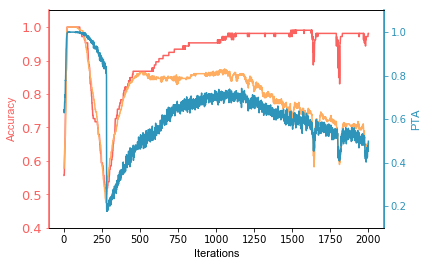

In [4]:
# plot the metrics values along with iterations
ax = plt.subplot(1,1,1)
p = ax.twinx()
trainColor = "#fa625f"
ptaColor = '#2E94B9'
testColor = '#ffad60'
ax.plot(ACC_PTA[:,0],color=trainColor,zorder=5,linewidth=1.5,label='Train Accuracy')
ax.plot(ACC_PTA[:,2],color=testColor,zorder=5,linewidth=1.5,label='Test Accuracy')
p.plot(ACC_PTA[:,1],color=ptaColor,zorder=5,linewidth=1.5,label='PTA')
ax.tick_params(axis='y',labelsize=13,labelcolor=trainColor,color=trainColor)
ax.set_ylabel('Accuracy',color=trainColor,fontsize=11, family='Arial')
ax.set_xlabel('Iterations',fontsize=11, family='Arial')
ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color(trainColor)
p.spines['left'].set_color(trainColor)
ax.set_ylim(0.4,1.05)
p.set_ylim(0.1,1.1)
p.set_ylabel('PTA',color=ptaColor,fontsize=11, family='Arial')#,loc='top'
p.tick_params(axis='y',labelsize=10,labelcolor=ptaColor,color=ptaColor)
ax.spines['right'].set_color(ptaColor)
p.spines['right'].set_color(ptaColor)
p.spines['right'].set_linewidth(1.5)